In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import pandas as pd

from astropy.time import Time
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy import constants as const

from scipy.optimize import curve_fit
from scipy.integrate import quad

import lightkurve as lk

import pickle

c:\Users\vishn\miniconda3\envs\SPT_Flares\lib\site-packages\lightkurve\config\__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to C:\Users\vishn\.lightkurve\cache. Please move all the files in the legacy directory C:\Users\vishn\.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
coinciding_flares_df = pd.read_pickle('..\data\spt_tess_candidates_tandoi24.pkl')
print(coinciding_flares_df.columns)
names = {'TIC207138379': 'Pike (M4.3)', 'TIC229807000': 'Andy(s) (Binary | M2.5Ve)', 'TIC279255411': 'Matt (Teff:6691 K)', 'TIC401838575': 'Liz (M5.5e)'}
coinciding_flares_df

Index(['index', 'spt_id', 'mjd', 'ts', 'ra', 'dec', '95_flux', '95_flux_err',
       '150_flux', '150_flux_err', '220_flux', '220_flux_err',
       'spectral_index_95_150', 'spectral_index_95_150_err',
       'spectral_index_150_220', 'spectral_index_150_220_err', 'dr3_source_id',
       'p-value', 'source_ra', 'source_dec', 'phot_g_mean_mag',
       'phot_bp_mean_mag', 'phot_rp_mean_mag', 'parallax', 'parallax_err',
       'binary', '2rxs_id', '2rxs_ref', '2rxs_flux', 'sectors', 'TIC'],
      dtype='object')


,index,spt_id,mjd,ts,ra,dec,95_flux,95_flux_err,150_flux,150_flux_err,...,phot_bp_mean_mag,phot_rp_mean_mag,parallax,parallax_err,binary,2rxs_id,2rxs_ref,2rxs_flux,sectors,TIC
0,42,SPT-SV J232857.8-680230,59067.63,69.829680,352.241137,-68.041907,33.132387,6.050987,44.396645,6.479653,...,13.298294,10.835975,21.814973,0.016096,True,2RXS J232857.7-680225,Freund,0.0,[28],TIC229807000
1,43,SPT-SV J220610.2-460354,59068.28,65.720511,331.542835,-46.065046,47.818806,8.045753,50.842904,8.377214,...,11.394999,10.820612,2.686802,0.032307,False,NaN,NaN,NaN,[28],TIC279255411
2,46,SPT-SV J025532.4-570257,59110.27,1233.665708,43.885140,-57.049441,162.083004,7.148120,206.963060,7.665012,...,16.325182,13.060138,21.889704,0.021013,False,NaN,NaN,NaN,[29],TIC207138379
3,49,SPT-SV J014432.2-460435,59131.78,48.975169,26.134435,-46.076393,45.598152,8.294850,36.632626,8.695313,...,18.198709,14.208293,25.949235,0.045132,False,NaN,NaN,NaN,[30],TIC401838575


In [3]:
coinciding_flares_df['dr3_source_id']

0    6388014157668558080
1    6567445491726233216
2    4727920241619206912
3    4954453580066220800
Name: dr3_source_id, dtype: int64

In [9]:
flare_star = coinciding_flares_df.iloc[3]
flare_star

index                                              49
spt_id                        SPT-SV J014432.2-460435
mjd                                          59131.78
ts                                          48.975169
ra                                          26.134435
dec                                        -46.076393
95_flux                                     45.598152
95_flux_err                                   8.29485
150_flux                                    36.632626
150_flux_err                                 8.695313
220_flux                                    44.396346
220_flux_err                                30.140886
spectral_index_95_150                       -0.479308
spectral_index_95_150_err                    0.654735
spectral_index_150_220                       0.501885
spectral_index_150_220_err                   1.877854
dr3_source_id                     4954453580066220800
p-value                                      0.020155
source_ra                   

In [10]:
SPT_SS = pd.read_csv('../data/SPT/flux_calibrated_catalog_scan_start_times_26feb25.csv')
spt_id = flare_star['spt_id']
gaia = flare_star['dr3_source_id']
TIC = flare_star['TIC']
print(names[TIC])

Liz (M5.5e)


# Full Synchrotron Energy Estimate

In [11]:
# Grab SPT Single Scan Data
ss_flux_str = SPT_SS[SPT_SS['DR3_source_id']== gaia]['ss_flux'].values[0]
ss_flux_str_dict = eval(ss_flux_str.replace('array', 'np.array'))
ss_flux_90 = ss_flux_str_dict['90GHz']
ss_flux_150 = ss_flux_str_dict['150GHz']

In [12]:
SPT_bands_GHz = {
    'BandCenter90': (101.2 * u.GHz, 1.2 * u.GHz),
    'BandWidth90': (22.7 * u.GHz, 0.6 * u.GHz),
    'BandCenter150': (153.8 * u.GHz, 1.3 * u.GHz),
    'BandWidth150': (37.7 * u.GHz, 1.2 * u.GHz),
}

d = (flare_star['parallax']*u.mas).to(u.kpc, equivalencies= u.parallax())

In [13]:
B_90 = (0.25 * d.to(u.kpc)**(-4/17) * (np.max(ss_flux_90) * u.mJy)**(-2/17) * SPT_bands_GHz['BandCenter90'][0]**(19/17))
B_150 = (0.25 * d.to(u.kpc)**(-4/17) * (np.max(ss_flux_150) * u.mJy)**(-2/17) * SPT_bands_GHz['BandCenter150'][0]**(19/17))
print(f'B_90: {B_90.value:3e} G | B_150: {B_150.value:3e} G')

R_90 = (1.68e12 * d.to(u.kpc)**(16/17) * (np.max(ss_flux_90) * u.mJy)**(8/17) * SPT_bands_GHz['BandCenter90'][0]**(-33/34))
R_150 = (1.68e12 * d.to(u.kpc)**(16/17) * (np.max(ss_flux_150) * u.mJy)**(8/17) * SPT_bands_GHz['BandCenter150'][0]**(-33/34))
print(f'R_90: {R_90.value:3e} cm | R_150: {R_150.value:3e} cm')

E_90 = (1.5e35 * d.to(u.kpc)**(40/17) * (np.max(ss_flux_90) * u.mJy)**(20/17) * SPT_bands_GHz['BandCenter90'][0]**(-23/34))
E_150 = (1.5e35 * d.to(u.kpc)**(40/17) * (np.max(ss_flux_150) * u.mJy)**(20/17) * SPT_bands_GHz['BandCenter150'][0]**(-23/34))
print(f'E_90: {E_90.value:3e} erg | E_150: {E_150.value:3e} erg')

T_B_90 = (3.5e10 * d.to(u.kpc)**(2/17) * (np.max(ss_flux_90) * u.mJy)**(1/17) * SPT_bands_GHz['BandCenter90'][0]**(-1/34))
T_B_150 = (3.5e10 * d.to(u.kpc)**(2/17) * (np.max(ss_flux_150) * u.mJy)**(1/17) * SPT_bands_GHz['BandCenter150'][0]**(-1/34))
print(f'T_B_90: {T_B_90.value:3e} K | T_B_150: {T_B_150.value:3e} K')

B_90: 5.587085e+01 G | B_150: 8.717108e+01 G
R_90: 7.021985e+09 cm | R_150: 5.127750e+09 cm
E_90: 5.470585e+32 erg | E_150: 5.185717e+32 erg
T_B_90: 2.697811e+10 K | T_B_150: 2.695580e+10 K


# Full Thermal Energy Estimate

In [14]:
fit_energy = 9.19E+32 * u.erg
fit_energy_err = 0 * u.erg
fit_duration= (59.83 * u.hour).to(u.s)


r_MDwarf = const.R_sun.to(u.cm) * 0.75
r_test = R_150.value * u.cm

fit_avg_lum = fit_energy / fit_duration
fit_avg_lum_err = fit_energy_err / fit_duration

## Fit Temperature

In [15]:
from astropy.modeling.models import BlackBody

In [16]:
def BB_Lum(T, nus, radius):
    # return ((2 * const.h * nu**3) / const.c**2 / (np.exp((const.h * nu / (const.k_B * T)).decompose()) - 1))
    bb_func = BlackBody(T)
    bb = bb_func(nus)

    spec_rad = np.trapz(x= nus, y= bb).to(u.erg / (u.cm**2 * u.s * u.sr))
    return (spec_rad * (np.pi * radius**2) * (np.pi * u.sr)).to(u.erg / u.s)

def TESS_BB(T, radius):
    nus = np.linspace((const.c / (1000*u.nm)), (const.c / (600*u.nm)), 1000).to(u.Hz)
    return BB_Lum(T, nus, radius)

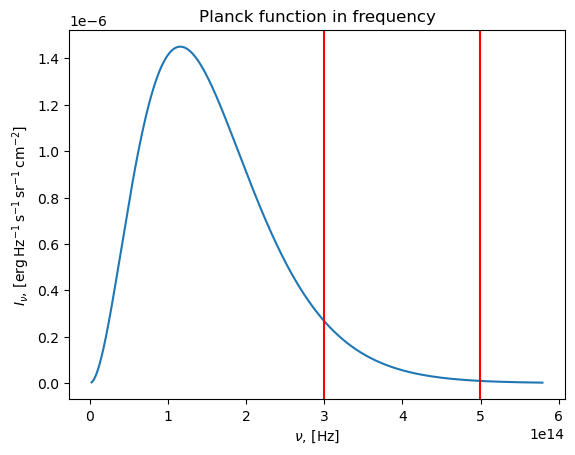

Fit Energy: 9.190e+32 erg ± 0.000e+00 erg
	Fit Luminosity: 4.267e+27 erg / s ± 0.000e+00 erg / s
Best T: 1970.67 K + 0.00 K / - 0.00 K K | Peak Frequency: 1.158e+02 THz
	TESS_BB Luminosity: 4.267e+27 erg / s + 0.000e+00 erg / s / - 0.000e+00 erg / s
	TESS_BB Energy: 9.190e+32 erg + 0.000e+00 erg / - 0.000e+00 erg
	Bolometric Energy: 1.521e+34 erg + 0.000e+00 erg / - 0.000e+00 erg


In [19]:
from scipy.optimize import minimize_scalar

TESS_lum_diff = lambda T, val: np.abs(TESS_BB(T * u.K, r_test) - val)
mid = minimize_scalar(TESS_lum_diff, bounds=(1000, 100000), method='bounded', args= (fit_avg_lum,))
upper_bound = minimize_scalar(TESS_lum_diff, bounds=(1000, 100000), method='bounded', args= (fit_avg_lum + fit_avg_lum_err,))
lower_bound = minimize_scalar(TESS_lum_diff, bounds=(1000, 100000), method='bounded', args= (fit_avg_lum - fit_avg_lum_err,))

best_T = mid.x * u.K
best_lum = TESS_BB(best_T, r_test)

upper_T = upper_bound.x * u.K
upper_lum = TESS_BB(upper_T, r_test)
del_T_up = upper_T - best_T
del_lum_up = upper_lum - best_lum

lower_T = lower_bound.x * u.K
lower_lum = TESS_BB(lower_T, r_test)
del_T_down = best_T - lower_T
del_lum_down = best_lum - lower_lum


ν_peak = (2.821 * const.k_B * best_T / const.h).to(u.Hz)
nu_min = (ν_peak / 50).to(u.Hz)
nu_max = (ν_peak * 5).to(u.Hz)

full_bb_nus = np.logspace(np.log10(nu_min.value), np.log10(nu_max.value), 1000) * u.Hz
bb = BlackBody(best_T)
full_bb = bb(full_bb_nus)
plt.plot(full_bb_nus, full_bb)
plt.axvline((const.c / (1000*u.nm)).to(u.Hz).value, c= 'r')
plt.axvline((const.c / (600*u.nm)).to(u.Hz).value, c= 'r')
plt.xlabel(r"$\nu$, [{0:latex_inline}]".format(full_bb_nus.unit))
plt.ylabel(r"$I_{\nu}$, " + "[{0:latex_inline}]".format(full_bb.unit))
plt.title("Planck function in frequency")
plt.show()

full_lum_best = BB_Lum(best_T, full_bb_nus, r_test)
full_lum_upper = BB_Lum(upper_T, full_bb_nus, r_test)
full_lum_lower = BB_Lum(lower_T, full_bb_nus, r_test)
del_full_lum_up = full_lum_upper - full_lum_best
del_full_lum_down = full_lum_best - full_lum_lower

print(f"Fit Energy: {fit_energy:.3e} ± {fit_energy_err:.3e}")
print(f"\tFit Luminosity: {fit_avg_lum:.3e} ± {fit_avg_lum_err:.3e}")
print(f"Best T: {best_T:.2f} + {del_T_up:.2f} / - {del_T_down:.2f} K | Peak Frequency: {ν_peak.to(u.THz):.3e}")
print(f"\tTESS_BB Luminosity: {best_lum:.3e} + {del_lum_up:.3e} / - {del_lum_down:.3e}")
print(f"\tTESS_BB Energy: {best_lum * fit_duration:.3e} + {del_lum_up * fit_duration:.3e} / - {del_lum_down * fit_duration:.3e}")
print(f"\tBolometric Energy: {full_lum_best * fit_duration:.3e} + {del_full_lum_up * fit_duration:.3e} / - {del_full_lum_down * fit_duration:.3e}")

## Assume 10000 K BB

5.878e+02 THz


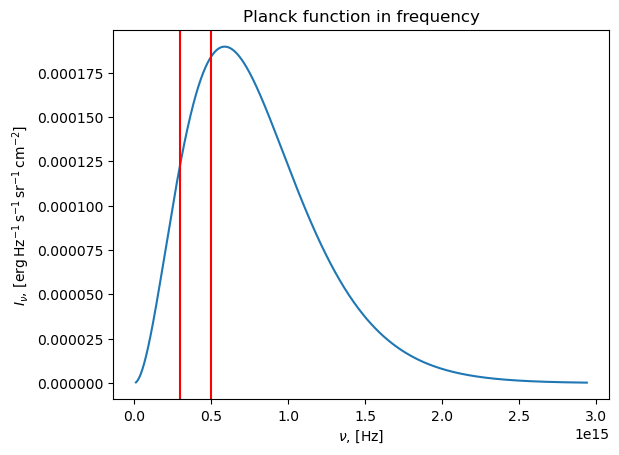

BB Lum 1.0084633541113559e+37 erg
TESS Band Lum 1.7793260042751643e+36 erg


In [20]:
T_test = 10000 * u.K

ν_peak = (2.821 * const.k_B * T_test / const.h).to(u.Hz)
nu_min = (ν_peak / 50).to(u.Hz)
nu_max = (ν_peak * 5).to(u.Hz)
print(f'{ν_peak.to(u.THz):.3e}')

full_bb_nus = np.logspace(np.log10(nu_min.value), np.log10(nu_max.value), 1000) * u.Hz
bb = BlackBody(T_test)
full_bb = bb(full_bb_nus)
plt.plot(full_bb_nus, full_bb)
plt.axvline((const.c / (1000*u.nm)).to(u.Hz).value, c= 'r')
plt.axvline((const.c / (600*u.nm)).to(u.Hz).value, c= 'r')
plt.xlabel(r"$\nu$, [{0:latex_inline}]".format(full_bb_nus.unit))
plt.ylabel(r"$I_{\nu}$, " + "[{0:latex_inline}]".format(full_bb.unit))
plt.title("Planck function in frequency")
plt.show()

print('BB Lum', BB_Lum(T_test, full_bb_nus, r_test) * fit_duration)
print('TESS Band Lum', TESS_BB(T_test, r_test) * fit_duration)

## Scale with GAIA Bol Luminosities
Idea Source: [https://www.aanda.org/articles/aa/abs/2022/05/aa43086-22/aa43086-22.html](https://www.aanda.org/articles/aa/abs/2022/05/aa43086-22/aa43086-22.html)

Only Matt and Andy(s) have the required values on the gaia catalog website

<span style="color:red;">Assumes quiescent and flare have same spectral shape</span>

Links to tool for calculationg Bolometric Correction (BC_g): https://gitlab.oca.eu/ordenovic/gaiadr3_bcg/ | https://www.cosmos.esa.int/web/gaia/dr3-bolometric-correction-tool


In [ ]:
from gdr3bcg.bcg import BolometryTable

table=BolometryTable()

dat = {
    'Matt': [6691.4, 4.2709, -0.3285, 0], # Alpha enhancement unknown atm and I have used 0
    'Andy(s)': [3235.6, 3.9101, -0.6766, 0], # Alpha enhancement unknown atm and I have used 0
}

BC_g = table.computeBc(dat['Matt'])
BC_g

In [ ]:
m_g = 11.180600 # Matt: 11.180600 | Andy: 11.975413
A_g = 0.0868 # Matt: 0.0868 | Andy: 0.1119
print(d.to(u.pc))
M_g = m_g + 5*np.log10((flare_star['parallax']*u.mas).to(u.arcsec).value) + 5 - A_g 

M_bol = M_g + BC_g

L_bol = const.L_sun * 10**(0.4 * (4.74 - M_bol))
L_bol.to(u.erg/u.s)

In [ ]:
TESS_quies_cnt = 6413.652 # Matt: 24761.474 | Andy: 6413.652
TESS_qies = (TESS_quies_cnt * 10**(-2/5*(20.44-16.4)) * u.mJy * (2e14 * u.Hz) * (4*np.pi*d.to(u.cm)**2)).to(u.erg/u.s) 
print(TESS_qies)
fit_energy * L_bol.to(u.erg/u.s) / TESS_qies

## BB 10000 K Shibayama 2013
https://ui.adsabs.harvard.edu/abs/2013ApJS..209....5S/abstract
